In [1]:
import os
from pathlib import Path
from cotnav.models.vlms import infer_registry
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# model_name = "o3"
# model_name = "o4-mini"
model_name = "gpt-5"
model_args = {
    "reasoning": {"effort": "low"},
    "text": {"verbosity": 'low'},
    "tools": [{"type": "code_interpreter", "container": {"type": "auto"}}],
    # "max_output_tokens": 384,
}

vlm_cfg = {
    "name": "openai",  # resolved by infer_registry.get(...)
    "provider_kwargs": {
        "model": model_name,
        "api_key": os.environ["OPENAI_API_KEY"],
        "timeout": 90.0,
        "default_model_args": model_args
    },
    "generate_defaults": {
        "instructions": "Answer concisely and focus on drivable-space cues."
    },
}

motion_cfg = {
    "max_curvature": 0.6,
    "max_free_path_length": 3.0,
    "num_options": 7,
    "pixels_per_meter": 120.0,
    "colors": [(255, 0, 0), (255, 255, 255), (0, 255, 0)],
    "thickness": 3,
    "endpoint_radius": 4,
    "alpha": 230,
}

annotation_cfg = {
    "thickness": 5,
    "endpoint_radius": 25,
    "overlay_alpha": 0.9,
    "label_font_size": 40,
    "label_font_color": (0, 0, 0),
}

In [3]:
pivot = infer_registry.get("pivot", vlm=vlm_cfg, motion_parameters=motion_cfg)


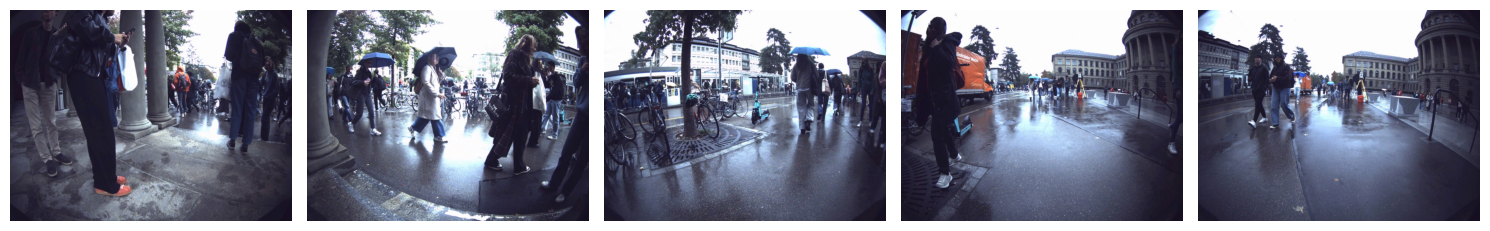

In [4]:
%matplotlib inline
from decord import VideoReader
from decord import cpu, gpu
import numpy as np
import matplotlib.pyplot as plt

from cotnav.utils.image_utils import (save_video)
from cotnav.utils.loader_utils import (load_intrinsics)
from cotnav.models.vlms.openaimodel import (
    ChatQuery, get_openai_cost
)

mission_dir = Path("/robodata/arthurz/Research/cotnav/data/grandtour_raw/mission_2024-10-01-12-00-49")
video_path = mission_dir / "front_camera_lossy.mp4"
ts_path   = mission_dir / "front_camera_timestamps_anymal.csv"
odom_path = mission_dir / "odometry_data_anymal.csv"
info_path = mission_dir / "front_camera_info_anymal.yaml"
tf_path = mission_dir / "tf_static_anymal.yaml"

START_FRAME = 3123
END_FRAME = 3363
FRAME_STEP = 2

assert all(p.exists() for p in [mission_dir, video_path, odom_path, info_path, ts_path, tf_path]), "One or more paths do not exist"

calib = load_intrinsics(info_path, tf_path, world_frame="base")

vr = VideoReader(str(video_path), ctx=cpu(0))
batch = vr.get_batch(np.arange(START_FRAME, END_FRAME, FRAME_STEP))
frames = batch.asnumpy()

plt.figure(figsize=(15, 6))
num_plots = 5
frame_indices = np.linspace(0, len(frames) - 1, num_plots, dtype=int)
for i, idx in enumerate(frame_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(frames[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Write batch to video file
save_video(frames, "test_output.mp4", fps=10)

In [ ]:
%pdb
import logging 

# Response gathering loop
with open("/robodata/arthurz/Research/cotnav/cotnav/models/prompts/openaiprompt.txt", "r") as f:
    system_prompt = f.read()

motion_arcs = pivot.motion_templates()
intermediate_prompts = [
    "Select the most promising path to the goal and explain why in one sentence.",
]
intermediate_prompts.extend(
    ["Given the previous observations and decisions, select the most promising path to the goal and explain why in one sentence."] * (len(frame_indices)-1)
)
assert len(intermediate_prompts) == len(frame_indices)
 
total_cost = 0
messages = []
annotated_images = []
intermediate_responses = []
for i, idx in enumerate(frame_indices):
    annotated_frame, centers = pivot.annotate_constant_curvature(
        frames[idx], arcs=motion_arcs, calib=calib, **annotation_cfg
    )
    prompt = intermediate_prompts[i]
    messages.append(ChatQuery("text", "user", prompt))
    messages.append(ChatQuery("image", "user", annotated_frame))

    response = pivot.vqa(system_prompt, messages)
    stage_response = ChatQuery("text", "assistant", response.output_text)
    messages.append(stage_response)
    intermediate_responses.append(response.output_text)
    cost, cost_breakdown = get_openai_cost(
        model_name,
        response.usage.input_tokens - response.usage.input_tokens_details.cached_tokens,
        response.usage.input_tokens_details.cached_tokens,
        response.usage.output_tokens
    )
    total_cost += cost
    logging.info(f"Cost for step {i}: ${cost:.6f}")
    logging.info(f"Cost breakdown: {cost_breakdown}")

logging.info(f"Total cost: ${total_cost:.6f}")

Automatic pdb calling has been turned ON


2025-10-07 10:44:09,541 - INFO - HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
2025-10-07 10:44:22,092 - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
2025-10-07 10:44:22,127 - INFO - Cost for step 0: $0.003349
2025-10-07 10:44:22,128 - INFO - Cost breakdown: {'input_cost': 0.0011687499999999999, 'cached_cost': 0.0, 'output_cost': 0.00218}
2025-10-07 10:44:25,620 - INFO - HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
2025-10-07 10:44:25,992 - INFO - HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK"
2025-10-07 10:44:39,261 - INFO - HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"
2025-10-07 10:44:39,262 - INFO - Cost for step 1: $0.005117
2025-10-07 10:44:39,263 - INFO - Cost breakdown: {'input_cost': 0.0015574999999999999, 'cached_cost': 0.0, 'output_cost': 0.00356}
2025-10-07 10:44:39,674 - INFO - HTTP Request: POST https://api.openai.com/v1/files "HTTP/1.1 200 OK

NameError: name 'logger' is not defined

> /tmp/ipykernel_3424595/3446182205.py(42)<module>()
     40     logging.info(f"Cost breakdown: {cost_breakdown}")
     41 
---> 42 logger.info(f"Total cost: ${total_cost:.6f}")
     43 
     44 # plt.figure(figsize=(8, 6))



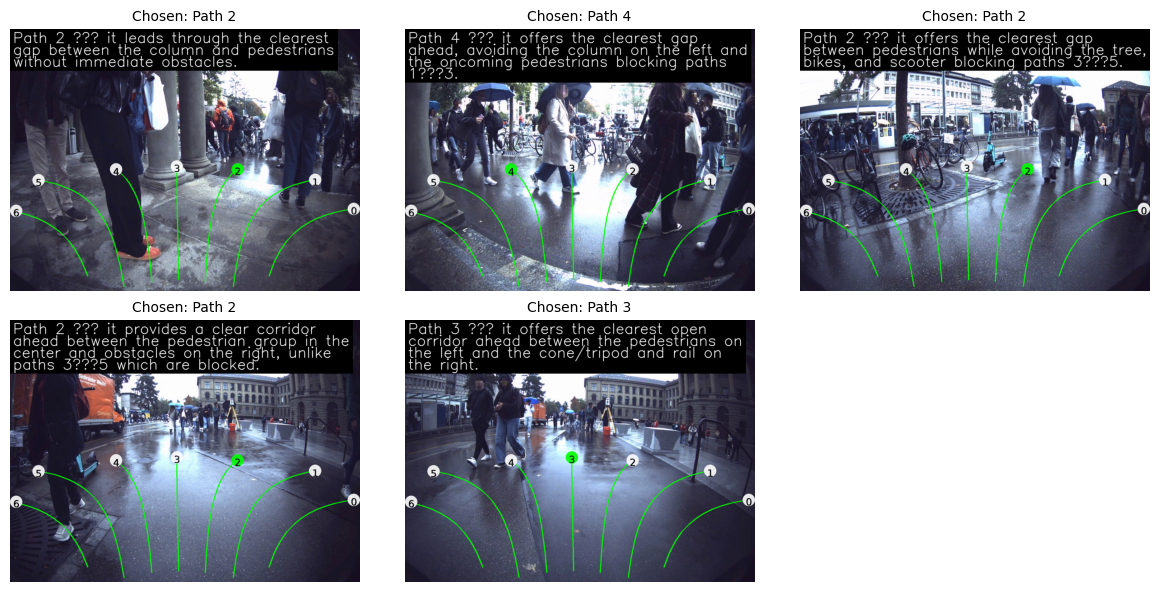

In [10]:
import re, math, cv2, textwrap
import numpy as np
import matplotlib.pyplot as plt


def extract_path_index(s: str):
    m = re.search(r'\bpath\W*?(\d+)\b', s, flags=re.I)
    return int(m.group(1)) if m else None

chosen_idxs = [extract_path_index(s) for s in intermediate_responses]

# --- 2) Small helper: draw wrapped instruction text with OpenCV ---
def draw_instruction_text(pil_img, text, margin=10, font_scale=0.6, thickness=2):
    """
    Draws instruction text at the top-left with a simple black box background.
    Uses OpenCV; returns a PIL.Image.
    """
    # PIL -> np (RGB)
    img = np.array(pil_img)
    H, W = img.shape[:2]

    font = cv2.FONT_HERSHEY_SIMPLEX
    color_text = (255, 255, 255)   # white
    color_bg   = (0, 0, 0)         # black

    # Wrap text to fit width using cv2's text size
    max_text_width = W - 2 * margin
    lines = []
    for paragraph in text.splitlines():
        if not paragraph.strip():
            lines.append("")  # keep blank lines
            continue
        words = paragraph.split()
        line = ""
        for w in words:
            trial = (line + " " + w).strip()
            (tw, th), _ = cv2.getTextSize(trial, font, font_scale, thickness)
            if tw <= max_text_width:
                line = trial
            else:
                if line:
                    lines.append(line)
                line = w
        if line:
            lines.append(line)

    # Compute block size
    line_height = cv2.getTextSize("Ag", font, font_scale, thickness)[0][1] + 6
    block_height = line_height * max(1, len(lines)) + 2 * margin
    block_width = max(
        (cv2.getTextSize(l or " ", font, font_scale, thickness)[0][0] for l in lines),
        default=0
    ) + 2 * margin

    # Clamp to image
    block_width = min(block_width, W)
    block_height = min(block_height, int(0.35 * H))  # don’t cover too much

    # Background rectangle
    cv2.rectangle(img, (0, 0), (block_width, block_height), color_bg, thickness=-1)

    # Draw lines
    y = margin + int(line_height * 0.9)
    for l in lines:
        cv2.putText(img, l, (margin, y), font, font_scale, color_text, thickness, cv2.LINE_AA)
        y += line_height
        if y > block_height - margin:
            break  # stop if we run out of box

    # back to PIL
    from PIL import Image
    return Image.fromarray(img)

# --- 3) Plot in a grid with matplotlib (no saving) ---
n = len(frame_indices)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)
plt.figure(figsize=(4*cols, 3*rows))

for i, idx in enumerate(frame_indices):
    # Use your already-computed motion_arcs/calib/annotation_cfg
    selected = chosen_idxs[i] if chosen_idxs[i] is not None else None

    # Re-annotate with the selected index so the chosen circle is green
    img_annot, _ = pivot.annotate_constant_curvature(
        frames[idx],
        arcs=motion_arcs,
        calib=calib,
        selected_idx=selected,
        **annotation_cfg
    )

    # Overlay the INSTRUCTION text (the prompt), using OpenCV
    img_with_text = draw_instruction_text(
        img_annot,
        intermediate_responses[i],
        margin=12,
        font_scale=2.0,
        thickness=2
    )

    # Show
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(img_with_text)
    title_idx = selected if selected is not None else "-"
    ax.set_title(f"Chosen: Path {title_idx}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()
